In [1]:
from collections import namedtuple
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline  
import os
import re 
import seaborn as sb
import pprint
from IPython.display import display, HTML

path = f'{os.environ["HOME"]}/exposure-bias/'
runs = os.listdir(path)
runs = list(filter(lambda x: os.path.isfile(os.path.join(path, x, 'test_results.csv')), runs))
runs = list(filter(lambda x: "has_film" in x, runs))  # filter for CelebA
files = list(map(lambda f: os.path.join(f, 'test_results.csv'), runs))
assert len(runs) > 0
print(runs)

['partial_exposure_1_has_film_763', 'zero_shot_1_has_film_234', 'partial_exposure_1_has_film_234', 'zero_shot_1_has_film_763', 'conflict_1_has_film_763', 'conflict_1_has_film_234']


In [2]:
prefix_len = 23

dfs = []
for fname in files:
    fpath = os.path.join(path, fname)
    
    fname = fname.replace('cnflct', 'conflict')
    fname = fname.replace('zr_sht', 'zero-shot')
    fname = fname.replace('prtl_xpsr', 'partial-exposure')
    fname = fname.replace('dscrmntr', 'discriminator')
    fname = fname.replace('dstrctr', 'distractor')
     
    df = pd.read_csv(fpath)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    if 'conflict' in fname:
        df['exposure condition'] = 'cue-conflict'
    elif 'zero_shot' in fname:
        df['exposure condition'] = 'zero-shot'
    elif 'partial_exposure' in fname:
        df['exposure condition'] = 'partial-exposure'
    else:
        ValueError('Unknown exposure condition.')
        
    # Backwards compat.
    #if 'discriminator attribute' not in df:
    #    matches = re.search('discriminator_([A-Za-z_]*)-distractor_([A-Za-z_]*)', fname)
    #    df['discriminator attribute'] = matches.group(1)
    #    df['distractor attribute'] = matches.group(2)
        
    dfs.append(df)
    
dfs[1].head()

,correct,discriminator,distractor,exposure condition
0,0,1,1,zero-shot
1,0,1,1,zero-shot
2,0,1,1,zero-shot
3,0,1,1,zero-shot
4,1,1,1,zero-shot


In [3]:
def p(df):
    display(HTML(df.to_html()))

from statistics import NormalDist

def confidence_interval(data, confidence=0.95):
  dist = NormalDist.from_samples(data)
  z = NormalDist().inv_cdf((1 + confidence) / 2.)
  h = dist.stdev * z / ((len(data) - 1) ** .5)
  return dist.mean - h, dist.mean + h

def summarize_df(df):
    Result = namedtuple('Result', ('exposure_condition', 
                                   #'discriminator_attribute',
                                   #'distractor_attribute',
                                   'mean_accuracy', 
                                   #'std_accuracy', 
                                   #'CI95_accuracy',
                                  ))
    return Result(df['exposure condition'].unique()[0], 
                  #df['discriminator attribute'].unique()[0],
                  #df['distractor attribute'].unique()[0],
                  df['correct'].mean(),
                  #df['correct'].std(),
                  #confidence_interval(df['correct']),
                  )

def filter_quadrants(df, disc, dist):
    return df.query(f'discriminator == {disc} & distractor == {dist}')

off_off_filter = partial(filter_quadrants, disc=0, dist=0)
on_off_filter = partial(filter_quadrants, disc=1, dist=0)
off_on_filter = partial(filter_quadrants, disc=0, dist=1)
on_on_filter = partial(filter_quadrants, disc=1, dist=1)

on_on_DF = pd.DataFrame(data=map(summarize_df, map(on_on_filter, dfs)))
on_off_DF = pd.DataFrame(data=map(summarize_df, map(on_off_filter, dfs)))
off_on_DF = pd.DataFrame(data=map(summarize_df, map(off_on_filter, dfs)))
off_off_DF = pd.DataFrame(data=map(summarize_df, map(off_off_filter, dfs)))
all_quadrants_DF = pd.DataFrame(data=map(summarize_df, dfs))

# Filter by >80% test accuracy on the second quadrant.
valid_idx = on_off_DF['mean_accuracy'] > 0.90
off_off_DF = off_off_DF[valid_idx]
on_off_DF = on_off_DF[valid_idx]
off_on_DF = off_on_DF[valid_idx]
on_on_DF = on_on_DF[valid_idx]
all_quadrants_DF = all_quadrants_DF[valid_idx]
all_quadrants_DF

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
from statistics import NormalDist

def ci95(x, confidence=0.95):
    if len(x) == 1:
        return np.NaN
    dist = NormalDist.from_samples(x)
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    return dist.stdev * z / ((len(x) - 1) ** .5)

def mean_ci95(x):
    return f"{np.mean(x) * 100:.2f}   ±   {ci95(x) * 100:.2f}%    (N={len(x)})"

def pivot(df):
    return pd.pivot_table(df, 
                          values=['mean_accuracy'], 
                          aggfunc=(mean_ci95,),
                          index=['discriminator_attribute',
                                 'distractor_attribute',],
                          columns=['exposure_condition'],
                         )

pivot(off_off_DF)

In [ ]:
pivot(on_off_DF)

In [ ]:
pivot(off_on_DF)

In [ ]:
pivot(on_on_DF)

In [7]:
from matplotlib.patches import Rectangle
grid_size = 3
cm = sb.diverging_palette(120, 271)

def show_values_on_bars(axs, h_v="v", space=0.4):
    """From https://stackoverflow.com/a/56780852."""
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + float(space)
                value = f"{p.get_height() * 100:.1f}%"
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() / 2
                value = f"{p.get_width() * 100:.1f}%"
                ax.text(_x, _y, value, ha="left", size=14, weight='bold')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def two_by_two(cond, disc, dist):
    assert cond in ['cue-conflict', 'partial-exposure', 'zero-shot']
    def acc_by_condition(df):
        accs = df[np.logical_and.reduce(
          (df["discriminator_attribute"] == disc, 
          df["distractor_attribute"] == dist,
          df["exposure_condition"] == cond,)
      )]['mean_accuracy']
        return np.mean(accs)#, ci95(accs)

    return np.transpose(
           [[acc_by_condition(off_off_DF), acc_by_condition(on_off_DF)], 
            [acc_by_condition(off_on_DF), acc_by_condition(on_on_DF)]]) 

shading = 2
purple = np.array([148, 103, 189]) / 255. / shading
green = np.array([ 44, 160,  44]) / 255. / shading


def plot_two_by_two(cc_df, zs_df, pe_df, x_axis_labels, y_axis_labels, title=None):
    # green to purple
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(grid_size*4, grid_size))
    #plt.suptitle(title)
    #fig.subplots_adjust(top=0.8)

    def heatmap(df, idx, condition_name, xlabel, ylabel):
        # mod bottom row data to be 1 - x
        mod_df = df.copy()
        mod_df[1, :] = 1 - mod_df[1, :]
        
        # plot heatmap
        ax = sb.heatmap(ax=axes[idx], data=mod_df, annot=df, fmt=f".1%", cmap=cm,
                        vmin=0, vmax=1, cbar=False, linewidths=10.0, linecolor='white',
                       )
        ax.tick_params(left=False, bottom=False)
        #ax.tick_params(labelleft=True, labelbottom=True)
        if xlabel:
            ax.set_xticklabels(x_axis_labels, rotation=0)
        else:
            ax.tick_params(labelbottom=False)
        if ylabel:
            ax.set_yticklabels(y_axis_labels, rotation=0)
        else:
            ax.tick_params(labelleft=False)
        ax.set_title(condition_name)
        
        linewidth = 4
        adjust = .08
        if not condition_name == 'Cue Conflict':
            ax.add_patch(Rectangle((0+.1, 0+adjust), 1-2*adjust, 1-2*adjust, ec=purple, fc='none', lw=linewidth, hatch='//'))
        if not condition_name == 'Zero-shot':
            ax.add_patch(Rectangle((1+adjust, 0+adjust), 1-2*adjust, 1-2*adjust, ec=purple, fc='none', lw=linewidth, hatch='//'))
        ax.add_patch(Rectangle((0+adjust, 1+adjust), 1-2*adjust, 1-2*adjust, ec=green, fc='none', lw=linewidth, hatch='//'))
        
        ax.texts[0].set_size(13)
        ax.texts[1].set_size(13)
        ax.texts[2].set_size(13)
        
        if condition_name == 'Cue Conflict':
            ax.texts[3].set_size(13)
        else:
            ax.texts[3].set_weight('bold')
            ax.texts[3].set_size(14)
        
        ax.hlines([1], *ax.get_xlim())

        
    heatmap(cc_df, 0, 'Cue Conflict', x_axis_labels, y_axis_labels)
    heatmap(zs_df, 1, 'Zero-shot', x_axis_labels, None)
    heatmap(pe_df, 2, 'Partial Exposure', x_axis_labels, None)
    
    pe_effect = sb.barplot(ax=axes[3], x=[zs_df[-1, -1] - pe_df[-1, -1]], y=[0],
               orient='h', color='orange')
    
    # make bar skinnier
    newwidth = .4
    bar = pe_effect.patches[0]
    x = bar.get_y()
    width = bar.get_height()
    centre = x + width/2.
    bar.set_y(centre - newwidth/2.)
    bar.set_height(newwidth)
    
    pe_effect.set(xlim=(0, 1))
    pe_effect.tick_params(left=False, bottom=True)
    pe_effect.tick_params(labelleft=False)#, labelbottom=False)
    pe_effect.set_title('Partial Exposure Effect')
    pe_effect.xaxis.set_major_formatter(PercentFormatter(1))
    show_values_on_bars(pe_effect, "h", 0.1)
    pe_effect.set_frame_on(False) #Remove both axes
    #pe_effect.axhline(0,color='black') #Put the x axis back
    
    # yticks
    plt.yticks(rotation=0)
    plt.savefig(f'{disc}_{dist}.png', dpi=300)
    plt.show()

a = np.array([[0, 10],
            [1, 11]])
a

In [ ]:
disc , dist = "Mth_Slghtl_pn", "Wrng_Lpstck"
plot_two_by_two(
    two_by_two('cue-conflict', disc, dist),
    two_by_two('zero-shot', disc, dist),
    two_by_two('partial-exposure', disc, dist),
    ['no\nlipstick', 'wearing\nlipstick'], ['mouth\nclosed', 'mouth\nslightly\nopen'], 
)

# Temporary visualization

This plot was generated based on hand-computed data, and should be replaced with the 4-quadrants plot.

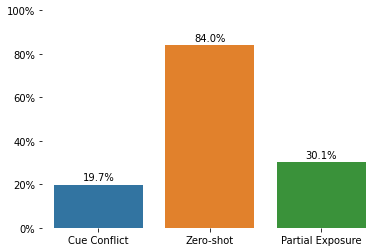

In [8]:
ax = sb.barplot(x=["Cue Conflict", "Zero-shot", "Partial Exposure"], 
                y=[0.197, 0.84,.301],
                
                )
ax.set(ylim=(0, 1))
ax.yaxis.set_major_formatter(PercentFormatter(1))
show_values_on_bars(ax, "v", 0.02)
ax.set_frame_on(False)
plt.savefig(f'imdb_accuracies.png', dpi=300)

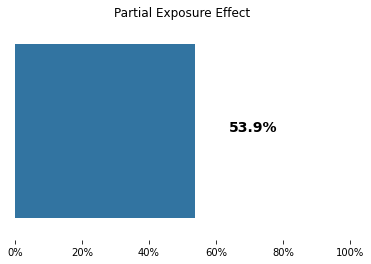

In [9]:
pe_effect = sb.barplot( x=[0.84 - .301], y=[0],
           orient='h', color='orange')

# make bar skinnier
newwidth = .4
bar = pe_effect.patches[0]
x = bar.get_y()
width = bar.get_height()
centre = x + width/2.
bar.set_y(centre - newwidth/2.)
bar.set_height(newwidth)

pe_effect.set(xlim=(0, 1))
pe_effect.tick_params(left=False, bottom=True)
pe_effect.tick_params(labelleft=False)#, labelbottom=False)
pe_effect.set_title('Partial Exposure Effect')
pe_effect.xaxis.set_major_formatter(PercentFormatter(1))
show_values_on_bars(pe_effect, "h", 0.1)
pe_effect.set_frame_on(False) #Remove both axes
#pe_effect.axhline(0,color='black') #Put the x axis back

ax = sb.barplot(y=["Partial Exposure Effect"], 
                 x=[0.84 - .301],
                orient='h'
                )
plt.savefig(f'imdb_partial_exposure.png', dpi=300)


In [10]:
disc , dist = "Wrng_Lpstck", "Mth_Slghtl_pn"
plot_two_by_two(
    two_by_two('cue-conflict', disc, dist),
    two_by_two('zero-shot', disc, dist),
    two_by_two('partial-exposure', disc, dist),
    ['mouth\nclosed', 'mouth\nslightly\nopen'], ['no\nlipstick', 'wearing\nlipstick']
)

NameError: name 'off_off_DF' is not defined

In [11]:
#plt.savefig(f'{disc}_{dist}.png', dpi=300)